# 가중치 적용 RFM Score를 바탕으로 한 군집 생성

* 로지스틱 회귀분석으로 도출된 가중치를 적용하여 최종 rfm score 생성 
* R(-0.49357152), F(1.02412651), M(0.23479531)

# 1. Raw Data 불러오기

In [1]:
# 라이브러리 불러오기

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings # 경고메세지 무시하기
warnings.filterwarnings(action='ignore')

<AxesSubplot:title={'center':'한글폰트'}>

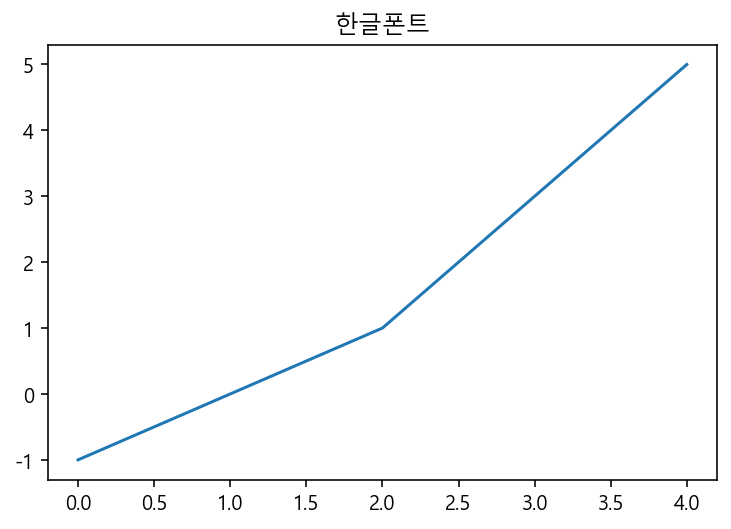

In [2]:
# 한글폰트

plt.rc("font", family="Malgun Gothic")
plt.rc("axes", unicode_minus=False) #마이너스 코드 
pd.options.display.float_format = '{:.3f}'.format
from IPython.display import set_matplotlib_formats #폰트 선명하게 설정.
set_matplotlib_formats('retina') 
pd.Series([-1,0,1,3,5]).plot(title="한글폰트") # 한글폰트와 마이너스 폰트 설정 확인

In [3]:
df_shop = pd.read_csv('df_shop.csv', parse_dates=['구매일자'])
df_shop = df_shop.drop(columns='Unnamed: 0', axis=1)
print(df_shop.shape)
df_shop.head()

(3447070, 14)


,ID,성별,연령대,시도,시군구,총_쇼핑소비금액,구매일자,구매시간,구매금액,구매수량,업종,소분류명,중분류명,대분류명
0,1,남성,60대,서울특별시,강동구,3899130,2015-12-16,17,28000,1,백화점,수입주방,주방용품,가정
1,1,남성,60대,서울특별시,강동구,3899130,2015-05-13,14,15000,1,백화점,수입주방,주방용품,가정
2,1,남성,60대,서울특별시,강동구,3899130,2015-08-01,19,166400,1,백화점,N/B골프의류,골프용품,스포츠
3,1,남성,60대,서울특별시,강동구,3899130,2015-12-28,12,166000,1,백화점,란제리,란제리/내의,여성의류
4,1,남성,60대,서울특별시,강동구,3899130,2015-05-13,12,1000,2,백화점,어묵,젓갈/반찬,식품


# 2. RFM df 생성

In [4]:
# Monetary 변수 생성

df_shop['총쇼핑금액'] = df_shop['구매금액'] * df_shop['구매수량'] # 수량 * 가격
rfm_m = pd.DataFrame(df_shop.groupby('ID')['총쇼핑금액'].sum().reset_index())
rfm_m.columns = ['CustomerID', 'Monetary']
rfm_m.head()

,CustomerID,Monetary
0,1,3899130
1,2,32593160
2,3,186048624
3,4,119248222
4,6,371031890


In [5]:
# Frequency 변수 생성

rfm_f = pd.DataFrame(df_shop.groupby(['ID'])['구매일자'].count().reset_index())
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,1,55
1,2,259
2,3,109
3,4,308
4,6,946


In [6]:
# Recency 변수 생성

max_date = max(df_shop['구매일자'])
df_shop['구매텀'] = max_date - df_shop['구매일자']
rfm_r = pd.DataFrame(df_shop.groupby('ID')['구매텀'].min().reset_index())
rfm_r['구매텀'] = rfm_r['구매텀'].dt.days # 일수만 추출
rfm_r.columns = ['CustomerID', 'Recency']
rfm_r.head()

,CustomerID,Recency
0,1,3
1,2,11
2,3,7
3,4,3
4,6,4


In [7]:
# r, f, m을 merge

rf_merge = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm = pd.merge(rf_merge, rfm_r, on='CustomerID', how='inner')
rfm.shape

(16892, 4)

# 3. RFM df 이상치 탐색 및 제거

Text(0, 0.5, '범위')

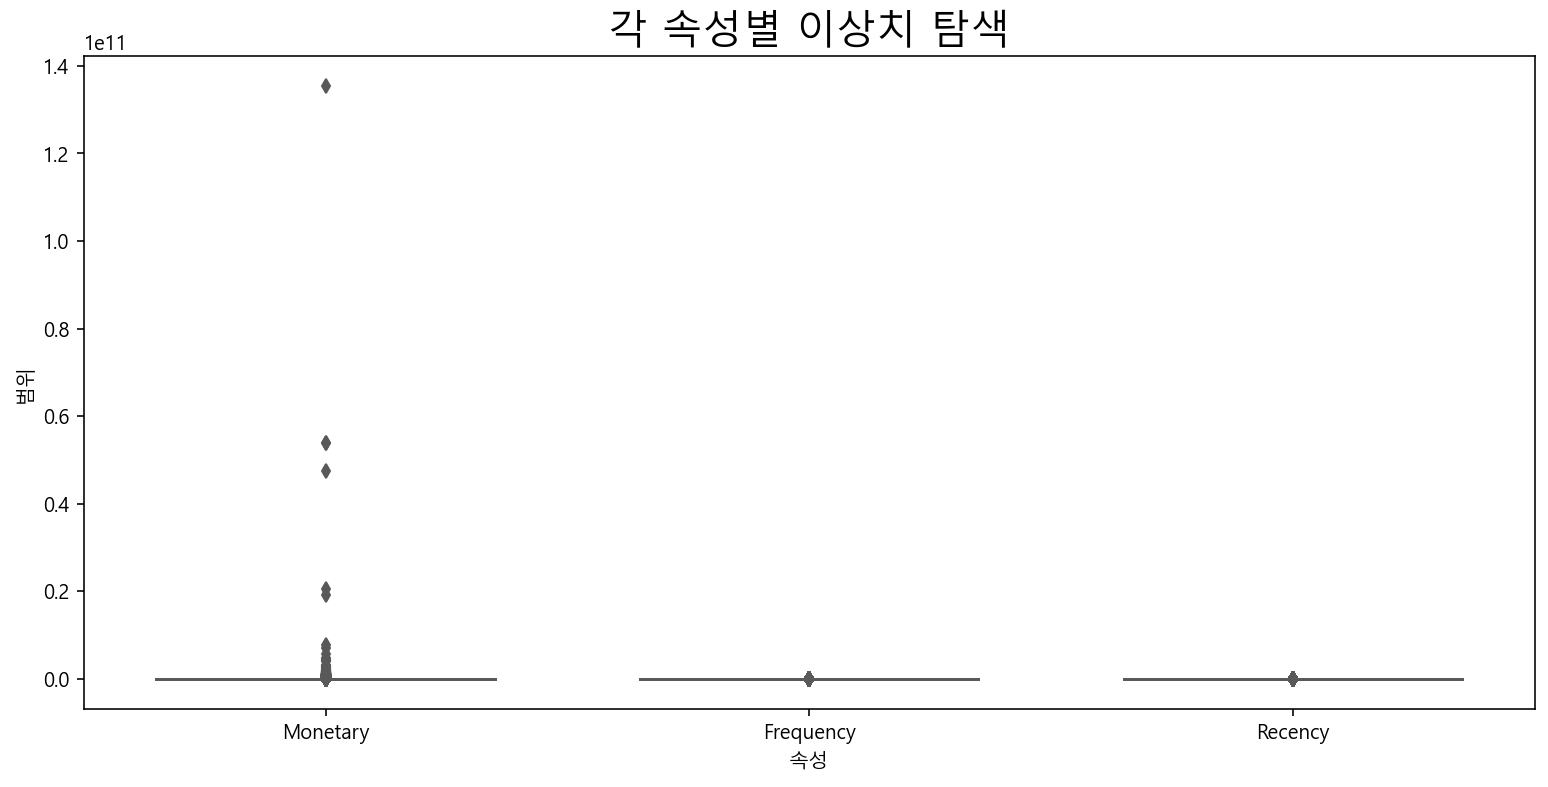

In [8]:
# 이상치 탐색

속성 = ['Monetary', 'Frequency', 'Recency']
plt.figure(figsize = (13, 6))
sns.boxplot(data=rfm[속성], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title('각 속성별 이상치 탐색', fontsize=20)
plt.xlabel('속성')
plt.ylabel('범위')

In [9]:
rfm.describe()

,CustomerID,Monetary,Frequency,Recency
count,16892.000,16892.000,16892.000,16892.000
mean,9542.647,73252175.027,204.065,38.378
std,5674.505,1281129525.860,271.062,66.476
min,1.000,400.000,1.000,0.000
25%,4648.750,1057849.250,29.000,4.000
50%,9354.500,6451688.000,104.000,10.000
75%,14317.250,36784250.500,273.000,37.000
max,20000.000,135411582841.000,5469.000,367.000


In [10]:
# 사분위수를 기준으로 이상치 제거

Q1 = rfm.Monetary.quantile(0.25)
Q3 = rfm.Monetary.quantile(0.75)
IQR = Q3 - Q1

# 해당하는 값의 범위만 rfm에 다시 할당
# 즉, 이상치를 제외

rfm = rfm[(rfm.Monetary >= Q1 - 1.5*IQR) & (rfm.Monetary <= Q3 + 1.5*IQR)]

# 이상치 처리시 다른 속성들도 같은 갯수여야 하므로 Frequency, Recency도 똑같이 처리

Q1 = rfm.Frequency.quantile(0.25)
Q3 = rfm.Frequency.quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]
Q1 = rfm.Recency.quantile(0.25)
Q3 = rfm.Recency.quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# 4. R, F, M별 Score 부여
* 사분위수를 기준으로 값 범위 선정 (min, 25%, 75%, max)
* 수치형 변수인 R, F, M를 범주형으로 라벨링

In [11]:
# 사분위수 확인

rfm.describe()

,CustomerID,Monetary,Frequency,Recency
count,11907.000,11907.000,11907.000,11907.000
mean,9735.151,13392234.393,123.235,22.483
std,5634.916,19294832.421,113.572,27.755
min,1.000,1300.000,1.000,0.000
25%,4932.000,1101939.000,32.000,4.000
50%,9645.000,4515285.000,87.000,10.000
75%,14410.000,16985480.500,184.000,30.000
max,20000.000,90369344.000,470.000,122.000


In [12]:
m_bins = [1299, 1101939, 16985480.5, 90369344]
f_bins = [0, 32, 184, 470]
r_bins = [-1, 4, 30, 122] 

rfm['m_score'] = pd.cut(rfm['Monetary'], m_bins, labels=[1, 2, 3])
rfm['f_score'] = pd.cut(rfm['Frequency'], f_bins, labels=[1, 2, 3])
rfm['r_score'] = pd.cut(rfm['Recency'], r_bins, labels=[3, 2, 1])

In [13]:
rfm.head()

,CustomerID,Monetary,Frequency,Recency,m_score,f_score,r_score
0,1,3899130,55,3,2,2,3
1,2,32593160,259,11,3,3,2
5,7,3705080,71,16,2,2,2
6,8,31647627,286,27,3,3,2
7,9,45683986,157,8,3,2,2


In [14]:
rfm.isnull().sum()

CustomerID    0
Monetary      0
Frequency     0
Recency       0
m_score       0
f_score       0
r_score       0
dtype: int64

In [15]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11907 entries, 0 to 16891
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   CustomerID  11907 non-null  int64   
 1   Monetary    11907 non-null  int64   
 2   Frequency   11907 non-null  int64   
 3   Recency     11907 non-null  int64   
 4   m_score     11907 non-null  category
 5   f_score     11907 non-null  category
 6   r_score     11907 non-null  category
dtypes: category(3), int64(4)
memory usage: 500.3 KB


In [16]:
# 스코어 점수가 category 이기에 int로 변형

rfm['m_score'] = rfm['m_score'].astype('int64')
rfm['f_score'] = rfm['f_score'].astype('int64')
rfm['r_score'] = rfm['r_score'].astype('int64')

# 5. 가중치 적용된 최종 RFM score 생성

In [17]:
# RMF 스코어 생성
rfm['rfm_score'] = 0.23479531*rfm['m_score'] +1.02412651*rfm['f_score'] -0.49357152*rfm['r_score']
rfm

,CustomerID,Monetary,Frequency,Recency,m_score,f_score,r_score,rfm_score
0,1,3899130,55,3,2,2,3,1.037
1,2,32593160,259,11,3,3,2,2.790
5,7,3705080,71,16,2,2,2,1.531
6,8,31647627,286,27,3,3,2,2.790
7,9,45683986,157,8,3,2,2,1.765
...,...,...,...,...,...,...,...,...
16887,19995,159600,1,6,1,1,2,0.272
16888,19996,378780,27,8,1,1,2,0.272
16889,19997,107224,22,1,1,1,3,-0.222
16890,19998,321700,9,5,1,1,2,0.272


In [18]:
# 만들어진 rfm_score의 구성 비율

rfm_score_ratio = rfm.groupby('rfm_score').agg({'Monetary':'mean', 'Frequency' : 'mean',
                             'Recency' : ['mean', 'count']}).round(1)
rfm_score_ratio

Monetary Frequency Recency      
                  mean      mean    mean count
rfm_score                                     
-0.222      454581.200    15.200   2.100   177
0.013      2994478.100    22.100   2.000    87
0.248     35027866.500    19.500   2.500     8
0.272       373726.600    13.600  15.300   741
0.507      3719699.300    21.800  14.100   342
0.741     37551712.700    21.700  15.300    53
0.765       328827.900    11.500  70.500  1165
0.802       605280.000    75.400   1.600   162
1.000      3970704.500    19.500  63.200   399
1.037      5894711.200   105.700   1.900   993
1.235     39375678.900    20.200  66.700    61
1.272     37733054.600   126.600   1.800   286
1.296       633259.500    69.700  13.400   424
1.531      5807418.700    93.200  12.800  2083
1.765     39221491.700   115.300  12.200   751
1.789       547484.000    59.300  62.400   257
1.826       906614.800   262.900   1.800    24
2.024      5377031.400    76.900  57.000   682
2.061      7337927.800   285.100   1.500   686
2.259     38840304.100    92.900  60.300   271
2.296     42468698.000   310.200   1.600   636
2.320       906333.500   224.100  12.100    27
2.555      7831811.100   278.900  10.400   629
2.790     44722346.600   299.100  10.100   845
3.048      5923199.800   267.400  49.900    52
3.283     44232694.300   264.800  50.400    66

In [19]:
# rfm_score별 고객 수

rfm_score_ratio = rfm.groupby('rfm_score').count().reset_index()
rfm_score_ratio = rfm_score_ratio[['rfm_score', 'CustomerID']]
rfm_score_ratio.columns = ['rfm_score', 'count']
rfm_score_ratio

,rfm_score,count
0,-0.222,177
1,0.013,87
2,0.248,8
3,0.272,741
4,0.507,342
5,0.741,53
6,0.765,1165
7,0.802,162
8,1.000,399
9,1.037,993


# 6. RFM Score를 바탕으로 한 고객 등급 생성
* rfm score값의 범위를 사분위수로 나누어 고객등급 부여
    * 실버: -0.222 ~ 0.775 (최소값 ~ 1사분위수값)
    * 골드: 0.776 ~ 2.210 (1사분위수값 ~ 3사분위수값)
    * 플래티넘: 2.211 ~ 3.283 (3사분위수값 ~ 최대값)

## 6.1 고객등급 부여

In [20]:
# rfm_score 값의 사분위수 확인

rfm_score_ratio['rfm_score'].describe()

count   26.000
mean     1.481
std      0.950
min     -0.222
25%      0.775
50%      1.413
75%      2.210
max      3.283
Name: rfm_score, dtype: float64

<AxesSubplot:ylabel='rfm_score'>

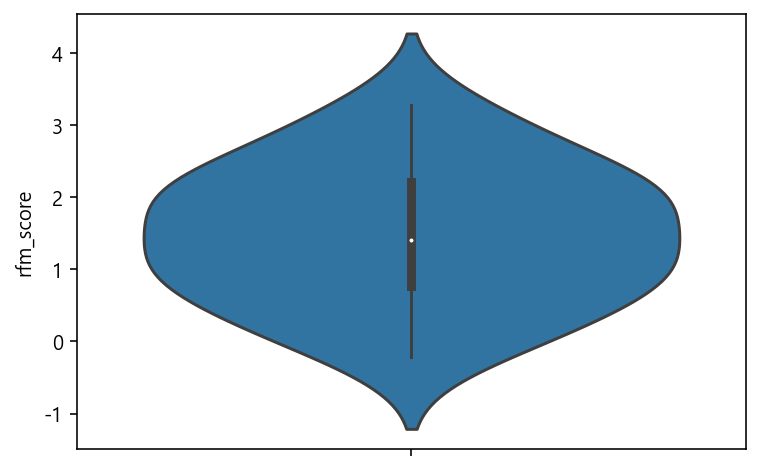

In [21]:
sns.violinplot(data=rfm_score_ratio, y='rfm_score')

In [22]:
# 정해진 rfm_score 범위대로 고객 등급 부여

rfm_cluster = ['실버','실버', '실버', '실버', '실버', '실버',
              '실버', '실버', '골드', '골드', '골드', '골드', '골드',
              '골드', '골드', '골드', '골드', '골드', '골드',
              '플래티넘', '플래티넘', '플래티넘','플래티넘', '플래티넘', '플래티넘', '플래티넘']
rfm_score_ratio['rfm_cluster'] = rfm_cluster
rfm_score_ratio = rfm_score_ratio.drop(columns='count', axis=1) # 필요없는 칼럼 지우기
rfm = pd.merge(rfm, rfm_score_ratio, how='left', on='rfm_score') # rfm 데이터와 merge
rfm

,CustomerID,Monetary,Frequency,Recency,m_score,f_score,r_score,rfm_score,rfm_cluster
0,1,3899130,55,3,2,2,3,1.037,골드
1,2,32593160,259,11,3,3,2,2.790,플래티넘
2,7,3705080,71,16,2,2,2,1.531,골드
3,8,31647627,286,27,3,3,2,2.790,플래티넘
4,9,45683986,157,8,3,2,2,1.765,골드
...,...,...,...,...,...,...,...,...,...
11902,19995,159600,1,6,1,1,2,0.272,실버
11903,19996,378780,27,8,1,1,2,0.272,실버
11904,19997,107224,22,1,1,1,3,-0.222,실버
11905,19998,321700,9,5,1,1,2,0.272,실버


In [23]:
# 등급별 고객 수 확인

y = rfm['rfm_cluster'].value_counts()
y

골드      6646
실버      2735
플래티넘    2526
Name: rfm_cluster, dtype: int64

In [24]:
rfm.head()

,CustomerID,Monetary,Frequency,Recency,m_score,f_score,r_score,rfm_score,rfm_cluster
0,1,3899130,55,3,2,2,3,1.037,골드
1,2,32593160,259,11,3,3,2,2.790,플래티넘
2,7,3705080,71,16,2,2,2,1.531,골드
3,8,31647627,286,27,3,3,2,2.790,플래티넘
4,9,45683986,157,8,3,2,2,1.765,골드


In [25]:
# 등급별 r,f,m score 평균값과 빈도수 비교

rfm.groupby('rfm_cluster').agg({'m_score' : 'mean', 'f_score' : 'mean', 'r_score' : ['mean', 'count']})

m_score f_score r_score      
               mean    mean    mean count
rfm_cluster                              
골드            2.059   2.038   2.089  6646
실버            1.201   1.059   1.733  2735
플래티넘          2.709   2.893   2.098  2526

* 등급별 rfm 점수의 평균값과 빈도를 확인해봤을 때 상위그룹에서 하위그룹으로 갈수록 각 점수가 타당한 것으로 나타났다
* 플래티넘 - 골드 - 실버 순으로 점수가 높다

<AxesSubplot:title={'center':'군집별 rfm score boxplot'}, xlabel='rfm_cluster', ylabel='rfm_score'>

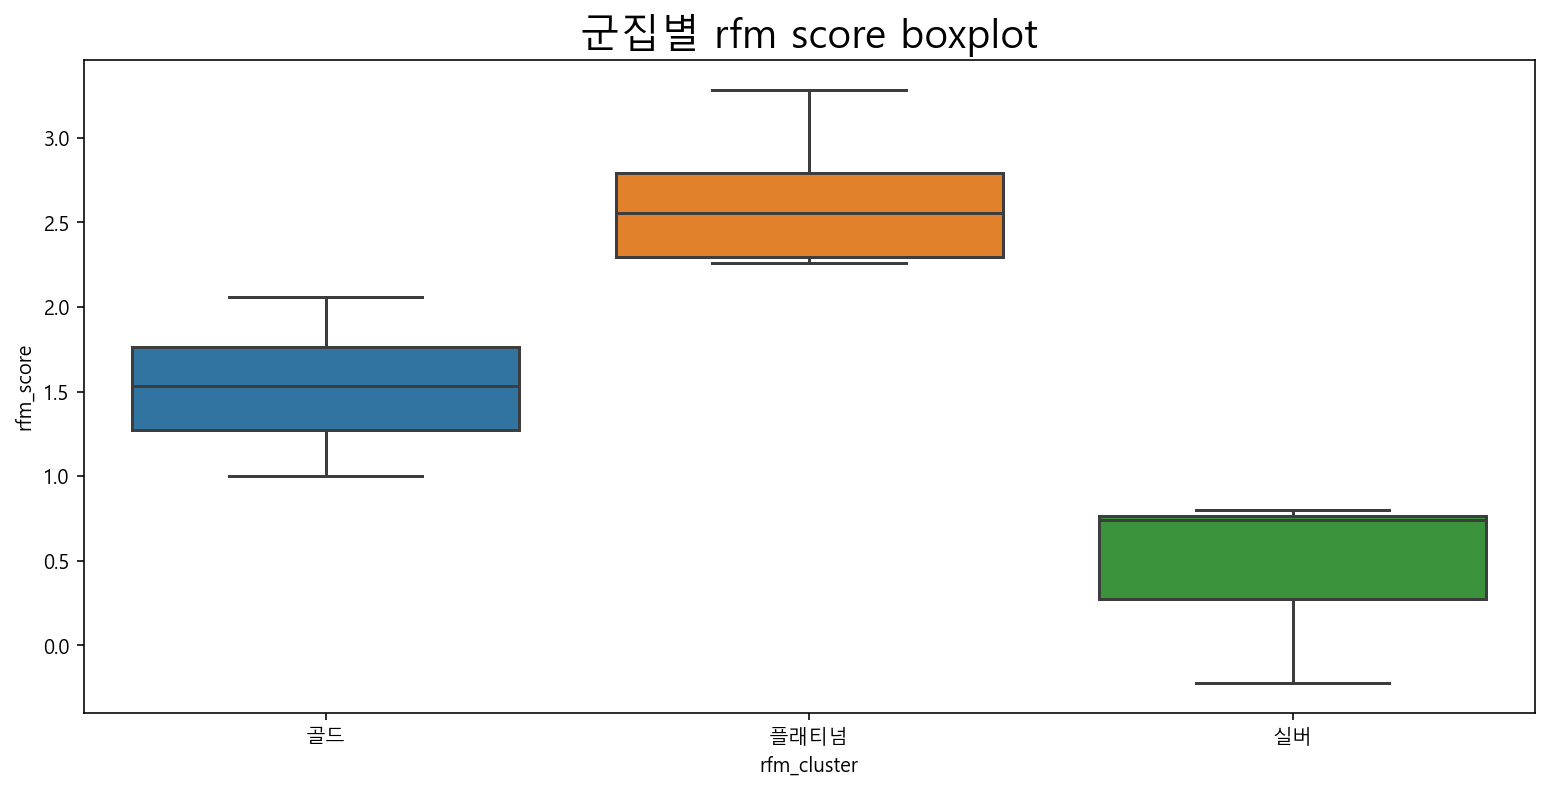

In [26]:
# 군집별 rfm_score boxplot

plt.figure(figsize=(13, 6))
plt.title('군집별 rfm score boxplot', fontsize=20)
sns.boxplot(data=rfm, x='rfm_cluster', y='rfm_score')

boxplot에서 보이는것처럼 등급별로 rfm score의 평균값 차이가 실제로 의미가 있는 차이일까?

## 6.2 등급 분류 검정
* 3개의 등급으로 세분화 된 집단이 적절히 분류되었는지 검토하기 위해 통계적인 분석 실시

In [27]:
# anova 분석을 위한 집단별 정규성 확인

from scipy.stats import shapiro

print(shapiro(rfm.rfm_score[rfm.rfm_cluster == '플래티넘']))
print(shapiro(rfm.rfm_score[rfm.rfm_cluster == '골드']))
print(shapiro(rfm.rfm_score[rfm.rfm_cluster == '실버']))

ShapiroResult(statistic=0.8502509593963623, pvalue=8.407790785948902e-44)
ShapiroResult(statistic=0.9010981917381287, pvalue=0.0)
ShapiroResult(statistic=0.7943221926689148, pvalue=0.0)


In [28]:
# 정규성 가정이 깨졌으므로 비모수검정인 크루스칼 왈리스 검정 실시

# 크루스칼 왈리스 검정은 anova에서 정규성 가정이 만족되지 않을 때 사용하는 비모수검정법
# anova와는 달리 중앙값에 관한 결과를 얻을 수 있다

# H0: 세 등급의 rfm_score의 중앙값은 모두 같다
# H1: 세 등급의 rfm_score의 중앙값에는 차이가 있다

import scipy.stats as stats

stats.kruskal(rfm.rfm_score[rfm.rfm_cluster == '플래티넘'],
             rfm.rfm_score[rfm.rfm_cluster == '골드'],
             rfm.rfm_score[rfm.rfm_cluster == '실버'])

KruskalResult(statistic=9660.279275089732, pvalue=0.0)

* 3개 등급의 집단에 대한 rfm score의 크루스칼 왈리스 검정 결과 p-value값이 0.000 미만으로 99% 신뢰수준에서 세 등급의 rfm_score의 중앙값은 모두 같다는 귀무가설을 기각
* 세 등급의 rfm_score의 중앙값 차이가 유의미하다고 말할 수 있다

In [29]:
# 사후 분석

from statsmodels.sandbox.stats.multicomp import MultiComparison
import scipy.stats

comp = MultiComparison(rfm.rfm_score, rfm.rfm_cluster)


# 비모수검정의 사후분석에 사용되는 Bonferroni correction을 이용하여 사후 분석 실시

result = comp.allpairtest(scipy.stats.ttest_ind, method='bonf')
result[0]

group1,group2,stat,pval,pval_corr,reject
골드,실버,133.7321,0.0,0.0,True
골드,플래티넘,-133.76,0.0,0.0,True
실버,플래티넘,-265.1577,0.0,0.0,True


본페로니 사후검증 방법을 사용하여 검증한 결과 모든 등급간의 중앙값 차이가 유의미한 것으로 나타났다 (p-value < 0.05)

# 7. 원본 Raw Data에 생성된 고객 등급 Merge

In [30]:
_ = pd.merge(df_shop, rfm, how='right', left_on = 'ID', right_on='CustomerID')
_.isnull().sum()

ID             0
성별             0
연령대            0
시도             0
시군구            0
총_쇼핑소비금액       0
구매일자           0
구매시간           0
구매금액           0
구매수량           0
업종             0
소분류명           0
중분류명           0
대분류명           0
총쇼핑금액          0
구매텀            0
CustomerID     0
Monetary       0
Frequency      0
Recency        0
m_score        0
f_score        0
r_score        0
rfm_score      0
rfm_cluster    0
dtype: int64

In [31]:
_.columns

Index(['ID', '성별', '연령대', '시도', '시군구', '총_쇼핑소비금액', '구매일자', '구매시간', '구매금액',
       '구매수량', '업종', '소분류명', '중분류명', '대분류명', '총쇼핑금액', '구매텀', 'CustomerID',
       'Monetary', 'Frequency', 'Recency', 'm_score', 'f_score', 'r_score',
       'rfm_score', 'rfm_cluster'],
      dtype='object')

In [32]:
# 불필요한 컬럼 삭제

df = _.drop(columns=['총_쇼핑소비금액', '총쇼핑금액', 'CustomerID', 'Monetary', 'Frequency', 'Recency', 'm_score', 'f_score', 'r_score', 'rfm_score',  '구매텀'],axis=1)

In [33]:
df = df.rename(columns={'rfm_cluster': '고객등급'})
df.head()

,ID,성별,연령대,시도,시군구,구매일자,구매시간,구매금액,구매수량,업종,소분류명,중분류명,대분류명,고객등급
0,1,남성,60대,서울특별시,강동구,2015-12-16,17,28000,1,백화점,수입주방,주방용품,가정,골드
1,1,남성,60대,서울특별시,강동구,2015-05-13,14,15000,1,백화점,수입주방,주방용품,가정,골드
2,1,남성,60대,서울특별시,강동구,2015-08-01,19,166400,1,백화점,N/B골프의류,골프용품,스포츠,골드
3,1,남성,60대,서울특별시,강동구,2015-12-28,12,166000,1,백화점,란제리,란제리/내의,여성의류,골드
4,1,남성,60대,서울특별시,강동구,2015-05-13,12,1000,2,백화점,어묵,젓갈/반찬,식품,골드


# 8. 고객 등급별 데이터 CSV 저장

In [34]:
# 고객 등급별로 데이터 저장

platinum = df[df['고객등급']=='플래티넘']
gold = df[df['고객등급']=='골드']
sliver = df[df['고객등급']=='실버']

In [35]:
# platinum.to_csv('플래티넘.csv',  index=False)
# gold.to_csv('골드.csv',  index=False)
# sliver.to_csv('실버.csv',  index=False)